In [2]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Notebook Contents:
- How to make up some data that we can apply PCA to.
- How to use the PCA() function from sklearn to do PCA.
- How to determine how much variation each principal component accounts for.
- How to draw a fancy PCA graph using matplotlip.
- How to examine the loading scores to determine what variable have the largest affect on the graph.

In [3]:
genes = ['gene' +str(i) for i in range(1,101)] #generate an array of 100 gene names
#create arrays of sample names.
wt = ['wt' + str(i) for i in range(1,6)] #5 "wild type" or 'wt' samples
ko = ['ko' + str(i) for i in range(1,6)] #5 'knock out" or 'ko' smaples

data = pd.DataFrame(columns=[*wt, *ko], index=genes) 
#The astrix * unpack the 'wt' and 'ko' arrays so that the columns names arr a single array that looks like:
#['wt1', 'wt2', 'wt3', 'wt4', 'wt5', 'ko1', 'ko2', 'ko3', 'ko4', 'ko5']
#without the * we would create an array of two arrays and that wouldn't create 12 columns like we want

for gene in data.index:
    #made up data comes from 2 poisson distributions, one for each sample: wt and ko
    data.loc[gene,'wt1':'wt5'] = np.random.poisson(lam=rd.randrange(10,1000), size=5)
    data.loc[gene,'ko1':'ko5'] = np.random.poisson(lam=rd.randrange(10,1000), size=5)

print('Shape:',data.shape)
data.T.head()

Shape: (100, 10)


,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene91,gene92,gene93,gene94,gene95,gene96,gene97,gene98,gene99,gene100
wt1,549,592,344,377,274,790,637,275,602,454,...,597,629,218,936,274,767,345,822,634,638
wt2,488,554,337,405,328,821,617,244,625,471,...,615,581,219,904,225,765,360,842,637,622
wt3,511,541,346,363,282,784,621,254,578,450,...,561,573,224,854,208,725,352,804,671,614
wt4,535,522,305,384,288,835,662,257,600,457,...,604,608,195,922,255,746,344,787,625,589
wt5,530,536,305,372,304,786,612,265,654,477,...,584,584,218,866,224,753,359,804,640,638


In [4]:
#Center and scale the data- after centering, the average value for each gene will be 0, and after scaling, 
# the standard deviation for the values for each gene will be 1.
#scaled_data = preprocessing.scale(data.T) #used in video, but less common for ML
#NOTE: we are passing in the transpose of our data because the genes are the features and gene data is stored as rows
# The scale function expects the samples to be rows instead of columns.

#Alternatively:
scaled_data = StandardScaler().fit_transform(data.T)

Notes from StandardScaler() documentation:
A common mistake is to apply scal to the entire data before splitting into training and test sets. This will bias the model evaluation because the information would have leaked from the test set to the training set. In general, it is recommended to use StandardScaler within a PIpeline i order to prevent most risks to data leaing: pipe = make_pipeline(StandardScaler(), LogisticRegression())

StandardScaler- Standardize features by removing the mean and scaling to unit variance.

In the example, the data is centered as scaled so that each gene (feature) has a mean=0 and stdv=1.
This is done so that all features are evaluated proportionally in relation to the data, so that the higher magnitude of one feature column doesn't skew the data.

The denominator in which variation is calculated differs between R and Python. 
In python variation eq: (measurements-mean)^2/# of measurements
In R variation eq: (measurements-mean)^2/(# of measurements-1)
The difference has no effect on PCA or eigenvector, but will result in minor effects on the final graph. This is because the coordinates on the final graph come from multiplying the loading scores by the scaled values.

In [5]:
#Creating PCA object to train on one dataset and apply on another
pca = PCA()
pca.fit(scaled_data) #calculating loading scores and variation each PC accounts for
pca_data = pca.transform(scaled_data) #generate coords for PCA graph based on loading scores and scaled data

In [9]:
#Skree plot to determine how many principal components to include
#calculate the %variation each PC accounts for
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

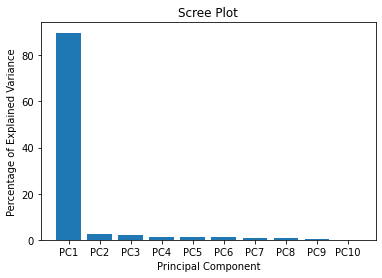

In [10]:
#Skree Plot
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Almost all of the variation is along the first PC, so a 2-D graph, using PC1 and PC2, should do a good job representing the original data.

In [11]:
pca_df = pd.DataFrame(pca_data, index=[*wt, *ko], columns=labels)
#put PCA data into a matrix where the rows have sample labels and the columns have PC labels.

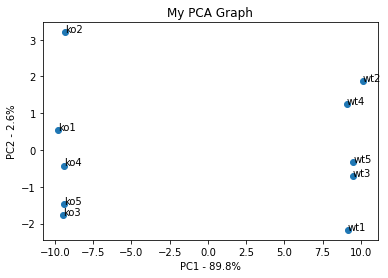

In [14]:
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index: #adds sample names to scatter
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

'wt' clusters together and 'ko' cluster together, suggesting they are correlated with eachother. And the sepatation of the two clusters along the x-axis suggests that 'wt' samples are very different from 'ko' sampels.

IMPORTANT!!!
Look at the loading scores for PC1 to determine which genes has the largest influence on separating the two clusters along the x-axis.

In [18]:
loading_scores = pd.Series(pca.components_[0], index=genes) #Create a series object with the loading scores in PC1
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)#sort the loading scores based on abs value

top_10_genes = sorted_loading_scores[0:10].index.values

In [20]:
print(loading_scores[top_10_genes])

gene11    0.105488
gene57   -0.105457
gene97    0.105453
gene56   -0.105405
gene47   -0.105400
gene90    0.105387
gene52   -0.105366
gene35   -0.105364
gene28   -0.105356
gene23   -0.105344
dtype: float64


These calues are super similar, so a lot of genes played a role in separating the samples, rather that just one or two. 